In [89]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [90]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
# Set up OpenAI LLM
llm = ChatOpenAI(model="gpt-4o", temperature=1.0)

# Prompts
greet_user_prompt = ChatPromptTemplate.from_template(
  """You are a fitness assistant.
     You're job is to greet user {userName}. 
""")

classifier_prompt = ChatPromptTemplate.from_template(
    """You are a fitness assistant.
    Categorize the user's feeling {feeling} into one of these: Energetic, Tired, Sore, or Stressed.
    User said: "{feeling}"
    Answer with ONLY the category."""
)

suggestion_prompt = ChatPromptTemplate.from_template(
    """You are a friendly fitness coach.
    Suggest a short daily workout for someone who feels {category}.
    Keep it motivating and simple (1-2 sentences).
    Provide motivational quote about fitness after suggesting workout considering the {category}."""
)

In [91]:
from langgraph.graph import StateGraph, END, START
from typing_extensions import TypedDict, List

# Define the state
class State(TypedDict):
    userName:str
    messages: List[str]
    feeling: str
    classify: str
    suggestion: str


In [92]:
#step 1. Greet User and ask about his mood today
def GreetUser(state:State):  
    name = state["userName"]
    # print('state name:', name)
    state['messages'].append(f"👋 Hello, **{name}**! I'm your Fitness Assistant.")
    state['messages'].append(f"👤 You reported feeling: *{state['feeling']}*")
    return state


In [93]:
#step 2. Classify user mood
def MoodClassifier(state:State):
  chain = classifier_prompt | llm 
  result = chain.invoke({"feeling": state["feeling"]})
  state['classify'] = result.content.strip()
  return state

In [94]:
#step 3. Suggest workout based on classification
def SuggestWorkout(state:State):
  chain = suggestion_prompt | llm
  result = chain.invoke({"category":state["classify"]})
  state["suggestion"] = result.content.strip()
  state["messages"].append(
        f"💡 Based on your feeling - ({state['classify']}), here’s my suggestion: {state['suggestion']}"        
    )
  state["messages"].append("✅ Logged for today. Keep pushing forward!")
  return state

In [95]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build graph
workflow = StateGraph(State)
workflow.add_node("GreetUser", GreetUser)
workflow.add_node("Classify mood", MoodClassifier)
workflow.add_node("Suggest workout based on mood", SuggestWorkout)

# Add transitions
workflow.add_edge(START, "GreetUser")
workflow.add_edge("GreetUser","Classify mood")
workflow.add_edge("Classify mood","Suggest workout based on mood")
workflow.add_edge("Suggest workout based on mood", END)

# Compile
chain = workflow.compile()

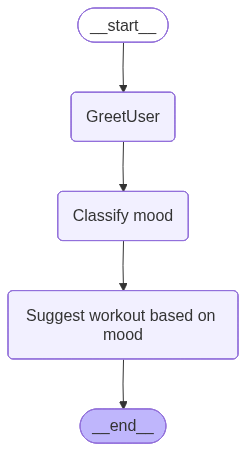

In [96]:
# Visualize
display(Image(chain.get_graph().draw_mermaid_png()))

In [98]:
import textwrap
# 1. Define the initial state
initial_state = {
    "userName": "",
    "messages": [], # Start with an empty list of messages
    "feeling": "", # Inject the user's input here
    "classify": "",
    "suggestion": ""
}

# 2. Take user input
initial_state["userName"] = input("Hey, what's your name?")
initial_state["feeling"] = input("Great! How you feeling today?")

# 3. Invoke the graph
# The graph starts at 'MoodClassifier' using the 'feeling' in the initial_state
final_state = chain.invoke(initial_state)

# 4. Print the final results (Your desired output format)
print("\n" + "="*40)
print("✨ Workout Recommendation Report ✨")
print("="*40)
print(f"Feeling: {final_state['feeling']}")
print(f"Classification: {final_state['classify']}")
print(f"Suggestion: {final_state['suggestion']}")
print("\n--- All Messages ---")
print(textwrap.indent("\n".join(final_state["messages"]), '   '))
print("="*40)


✨ Workout Recommendation Report ✨
Feeling: I'm feeling dizzy today
Classification: Tired
Suggestion: Here's a gentle and energizing routine for you: Start with a 5-minute walk to get your body moving, then follow it up with 5 minutes of stretching to ease any tension. Remember, "Even a short burst of movement is a step towards a stronger you. Rest today, conquer tomorrow."

--- All Messages ---
   👋 Hello, **Omkar**! I'm your Fitness Assistant.
   👤 You reported feeling: *I'm feeling dizzy today*
   💡 Based on your feeling - (Tired), here’s my suggestion: Here's a gentle and energizing routine for you: Start with a 5-minute walk to get your body moving, then follow it up with 5 minutes of stretching to ease any tension. Remember, "Even a short burst of movement is a step towards a stronger you. Rest today, conquer tomorrow."
   ✅ Logged for today. Keep pushing forward!
